# Quantification of Positive Pixel Masks

## Part 0: Setup

In the previous notebooks, we've shown how to start from a WSI and arrive at a positive pixel mask. In this notebook, we show how SANA can be used to convert such masks into quantitative information.

The code below utilizes the previous 3 example notebooks to load in 2 different ROIs into memory, process them, and cortically deform 1 of them

2025-04-29 13:25:00,466 :: DEBUG :: logging.py :: <func> debug :: Line: 72 :: Loading Frame from .svs slide file...
2025-04-29 13:25:00,540 :: DEBUG :: logging.py :: <func> debug :: Line: 72 :: Done I/O (0.07 sec)
2025-04-29 13:25:00,542 :: DEBUG :: logging.py :: <func> debug :: Line: 72 :: Loading Frame from .svs slide file...
2025-04-29 13:25:01,414 :: DEBUG :: logging.py :: <func> debug :: Line: 72 :: Done I/O (0.87 sec)


Text(0.5, 0.98, 'Normalized Cortex ROI')

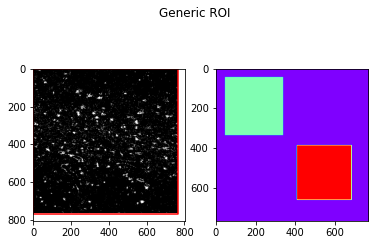

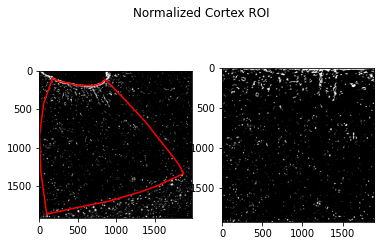

In [ ]:
import os
import geojson
from matplotlib import pyplot as plt
import numpy as np

import pdnl_sana.interpolate
import pdnl_sana.logging
import pdnl_sana.slide
import pdnl_sana.geo
import pdnl_sana.process
import pdnl_sana.filter
import pdnl_sana.image
import pdnl_sana as sana

def load_annotations(f, class_name, roi_name=None):
    annotations = geojson.load(open(f, 'r'))["features"]
    out = []
    for annotation in annotations:
        if annotation["properties"]["classification"]["name"] == class_name and (roi_name is None or annotation["properties"]["name"] == roi_name):
            if annotation["geometry"]["type"] == "Polygon":
                x, y = np.array(annotation["geometry"]["coordinates"][0]).T
                out.append(sana.geo.Polygon(x, y, is_micron=False, level=0))
            elif annotation["geometry"]["type"] == "LineString":
                x, y = np.array(annotation["geometry"]["coordinates"]).T
                out.append(sana.geo.Curve(x, y, is_micron=False, level=0))
    return out

SANAPATH = os.path.expanduser('~/sana_builds/main')

# grab all the necessary annotations
f = f'{SANAPATH}/docs/source/resources/example.geojson'
main_roi = load_annotations(f, "ROI")[0]
sub_rois = [load_annotations(f, "SUB_A")[0], load_annotations(f, "SUB_B")[0]]
exclusion_rois = load_annotations(f, "EXCLUDE")
top = load_annotations(f, "Top", "ROI_1")[0]
right = load_annotations(f, "Right", "ROI_1")[0]
bottom = load_annotations(f, "Bottom", "ROI_1")[0]
left = load_annotations(f, "Left", "ROI_1")[0]

# clip the segments at the 4 intersection points of the pseudo-quadrilateral so that we can create a polygon
main_seg = sana.geo.connect_segments(*sana.interpolate.clip_quadrilateral_segments(top, right, bottom, left))

# prepare I/O
logger = sana.logging.Logger(debug_level='debug', fpath=f'{SANAPATH}/docs/source/resources/example.pkl')
loader = sana.slide.Loader(logger=logger, fname=f'{SANAPATH}/docs/source/resources/example.tif', mpp=0.25225)

# load a frame based on the generic ROI annotations
roi_frame = loader.load_frame_with_roi(main_roi)
main_roi = sana.geo.transform_array_with_logger(main_roi, logger)
sub_rois = [sana.geo.transform_array_with_logger(x, logger) for x in sub_rois]
exclusion_rois = [sana.geo.transform_array_with_logger(exclusion_roi, logger) for exclusion_roi in exclusion_rois]

# load a frame based on the cortical segmentation annotations
seg_frame = loader.load_frame_with_segmentations(top, right, bottom, left, level=0)
top, right, bottom, left, main_seg = [sana.geo.transform_array_with_logger(x, logger) for x in [top, right, bottom, left, main_seg]]

# process the ROI
kwargs = {'main_roi': main_roi, 'sub_rois': sub_rois, 'exclusion_rois': exclusion_rois}
roi_results = sana.process.HDABProcessor(logger, roi_frame, apply_smoothing=True, normalize_background=True, **kwargs).run()

# process the SEG
kwargs = {'main_roi': main_seg}
seg_results = sana.process.HDABProcessor(logger, seg_frame, apply_smoothing=True, normalize_background=True, **kwargs).run()

# deform the SEG
sample_grid, angles = sana.interpolate.fan_sample(top, right, bottom, left, degrees=2, N=10)
deformed_frame = sana.interpolate.grid_sample(seg_frame, sample_grid)
deformed_pos = sana.interpolate.grid_sample(seg_results['positive_dab'], sample_grid)
deformed_mask = sana.interpolate.grid_sample(seg_results['main_mask'], sample_grid)
deformed_neg = sana.interpolate.grid_sample(seg_results['exclusion_mask'], sample_grid)

# display our hard work
fig, axs = plt.subplots(1,2)
axs[0].imshow(roi_results['positive_dab'].img, cmap='gray')
axs[0].plot(*main_roi.T, color='red')
axs[1].imshow(roi_results['main_mask'].img + roi_results['sub_masks'][0].img + 2*roi_results['sub_masks'][1].img , cmap='rainbow')
fig.suptitle('Generic ROI')
fig, axs = plt.subplots(1,2)
axs[0].imshow(seg_results['positive_dab'].img, cmap='gray')
axs[0].plot(*main_seg.T, color='red')
axs[1].imshow(deformed_pos.img & deformed_mask.img & (1-deformed_neg.img), cmap='gray')
fig.suptitle('Normalized Cortex ROI')

## Part 1: AO

To quantify a processed ROI, we utilize %Area Occupied. This is a simple calculation that essentially represents the density of positive pixels in the ROI.

$$\textnormal{\%Area Occupied} = \frac{\textnormal{\# Positive Pixels}}{\textnormal{Area of ROI}} = \frac{P}{A}$$

The code provided in this module does not explicitly perform the AO division however, as there are often times when we want to know the area used in a given AO measurement. For example, to calculate the average of 2 AO values it may be beneficial to perform a weighted average

$$\textnormal{Weighted Avg. of }AO_1\textnormal{ and }AO_2 = \frac{AO_1*A_1 + AO_2*A_2}{A_1 + A_2} = \frac{P_1+P_2}{A_1+A_2}$$



In [2]:
import sana.quantify

# get the positive pixels and area pixels of the Main-ROI
main_num, main_den = sana.quantify.calculate_ao(
    pos=roi_results['positive_dab'], 
    mask=roi_results['main_mask'],
    neg=roi_results['exclusion_mask'],
)

# for each Sub-ROI, calculate AO
sub_nums, sub_dens = [], []
for sub_mask in roi_results['sub_masks']:
    num, den = sana.quantify.calculate_ao(roi_results['positive_dab'], sub_mask)
    sub_nums.append(num)
    sub_dens.append(den)

# display the AO of our Frame
print('Main ROI:\t%d/%d = %0.2f%%' % (main_num, main_den, 100*main_num/main_den))
for sub_name, sub_num, sub_den in zip(['Sub ROI A', 'Sub ROI B'], sub_nums, sub_dens):
    print('%s:\t%d/%d = %0.2f%%' % (sub_name, sub_num, sub_den, 100*sub_num/sub_den))


Main ROI:	22336/580091 = 3.85%
Sub ROI A:	3865/84681 = 4.56%
Sub ROI B:	3520/75076 = 4.69%


## Part 2: Cortical Depth Analysis

In addition to %Area Occupied, if the processed frame has been deformed we can perform an analysis as a function of cortical depth

SEG:	160768/3619966 = 4.44%


Text(0.5, 0, '%AO')

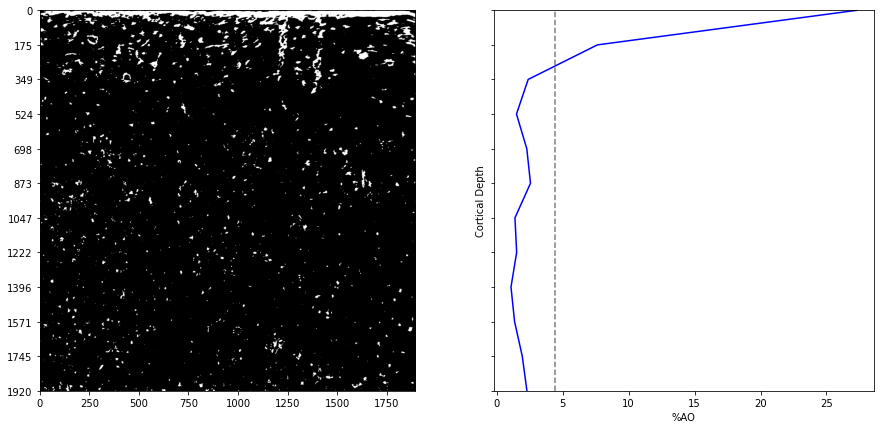

In [3]:

# AO calculation of the SEG
num, den = sana.quantify.calculate_ao(
    pos=deformed_pos, 
    mask=deformed_mask,
    neg=deformed_neg,
)
print('SEG:\t%d/%d = %0.2f%%' % (num, den, 100*num/den))

# bin the cortex into nbins
nbins = 12
num_bins, den_bins = sana.quantify.bin_cortex(
    frame=deformed_pos, 
    mask=deformed_mask,
    neg=deformed_neg,
    nbins=nbins,
)

# plot the cortical AO signal
fig, axs = plt.subplots(1,2, sharey=True, figsize=(15,7))
axs[0].imshow(deformed_pos.img & (1-deformed_neg.img), cmap='gray')
axs[1].plot(100*num_bins/den_bins, np.linspace(0, deformed_pos.size()[1], num_bins.shape[0]), color='blue')
axs[1].axvline(100*num/den, linestyle='--', color='gray')
axs[0].set_ylim([deformed_pos.img.shape[0], 0])
axs[1].set_ylabel('Cortical Depth')
axs[1].set_yticks(np.linspace(0, deformed_pos.size()[1], nbins))
axs[1].set_xlabel('%AO')


## Part 3: ROI Subsampling

To avoid sampling bias, SANA provides methods to subsample the given ROI using various methods. For reproducibility, the Sampler object exposes the seed argument which allows us to reproduce the same pseudo-random occurences

### Part 3a: Random Tile Sampling

This method allows us to randomly sample NxN tiles throughout the image

Mean AO = 4.10 -- STD: 2.23
Weighted AO = 4.13


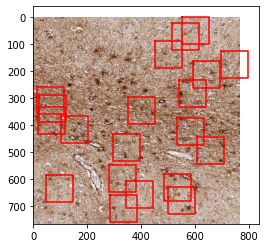

In [4]:
sampler = sana.quantify.Sampler(seed=42, pos=roi_results['positive_dab'], mask=roi_results['main_mask'])

# calculates AO of 20 randomly sampled 100x100 pixel tiles (works out to ~25 microns^2)
nums, dens, locs, sizes = sampler.subsample_tiles(l=100, N=20, debug=True)
aos = np.array(nums) / np.array(dens)
print("Mean AO = %.2f -- STD: %.2f" % (100*np.mean(aos), 100*np.std(aos)))
print("Weighted AO = %.2f" % (100*np.sum(nums) / np.sum(dens)))

fig, ax = plt.subplots(1,1)
ax.imshow(roi_frame.img)
for loc, size in zip(locs, sizes):
    ax.plot(*sana.geo.rectangle_like(main_roi, loc, size).T, color='red')

### Part 3b: Random Grid Sampling

This method first creates a grid of NxN tiles, then samples a certain percentage of those tiles. Optionally we can force the program to avoid adjacent tiles as much as possible, or avoid sampling tiles which are not entirely within the mask.

Raw AO = 72625/2202105=3.30%
Mean AO = 2.47 -- STD: 2.927191


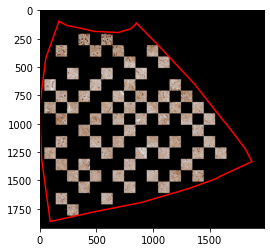

In [5]:
# results = roi_results
# poly = main_roi
# plot_frame = roi_frame.copy()
results = seg_results
poly = main_seg
plot_frame = seg_frame.copy()

num, den = sana.quantify.calculate_ao(pos=results['positive_dab'], mask=results['main_mask'], neg=results['exclusion_mask'])
print(f"Raw AO = {num}/{den}={100*num/den:.2f}%")

sampler = sana.quantify.Sampler(seed=42, pos=results['positive_dab'], mask=results['main_mask'], neg=results['exclusion_mask'])

# calculates the AO of 30% of a grid of 100x100 pixel tiles (~25 microns^2)
nums, dens, locs, sizes = sampler.subsample_grid(l=100, pct=0.30, avoid_adjacent=True, avoid_partial=True)
aos = [num/den for num, den in zip(nums, dens) if den != 0]
print(f"Mean AO = {100*np.mean(aos):.2f} -- STD: {100*np.std(aos):2f}")

# create the mask of the subsampled pixels
rects = [sana.geo.rectangle_like(main_roi, loc, size) for loc, size in zip(locs, sizes)]
subsample_mask = sana.image.create_mask_like(plot_frame, rects)

# plot the subsampled pixels
plot_frame.mask(results['main_mask'])
plot_frame.mask(results['exclusion_mask'], invert=True)
plot_frame.mask(subsample_mask)
fig, ax = plt.subplots(1,1)
_ = ax.imshow(plot_frame.img)
_ = ax.plot(*poly.T, color='red')


### Part 3c: Cortical Ribbon Subsampling

If the frame was deformed, we can subsample a contiguous ribbon of cortex based on a given percentage of the width

Subsampled AO = 42303/908153=4.66%


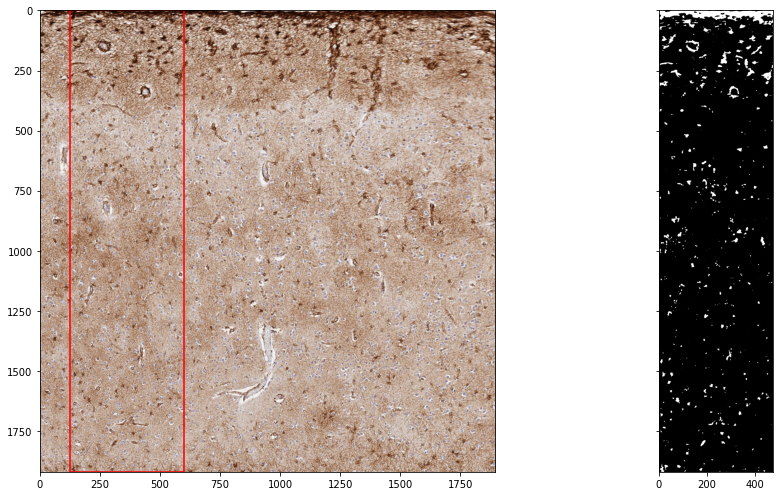

In [6]:
sampler = sana.quantify.Sampler(seed=42, pos=deformed_pos, mask=deformed_mask, neg=deformed_neg)

# contiguously sampling 25% of the cortex
num, den, loc, size, pos, mask, neg = sampler.subsample_ribbon(pct=0.25)
print(f"Subsampled AO = {num}/{den}={100*num/den:.2f}%")

fig, axs = plt.subplots(1,2, sharey=True, figsize=(15,7))
axs[0].imshow(deformed_frame.img)
axs[0].plot(*sana.geo.rectangle_like(main_seg, loc, size).T, color='red')
axs[1].imshow(pos.img * mask.img * (1-neg.img), cmap='gray')
fig.tight_layout()

### Part 3d: Cortical Column Subsampling

Finally, we provide an interface for sampling random columns of the cortex. This has the benefit of each column having an equal probability of being sampled, in contrast to the method above where the columns in the middle are much more likely to be sampled than columns at the edges

Subsampled AO = 39762/903327=4.40%


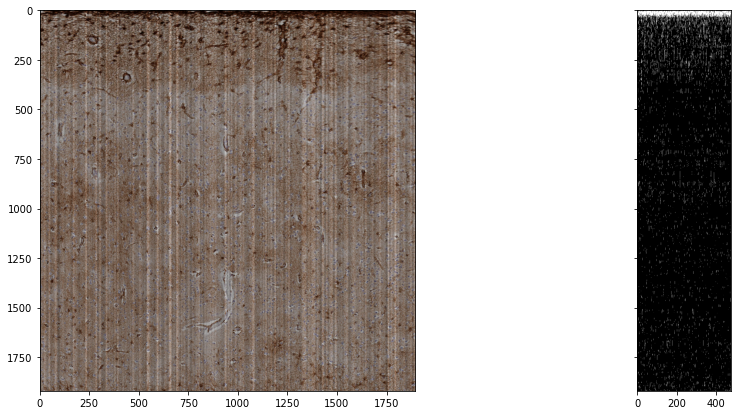

In [7]:
sampler = sana.quantify.Sampler(seed=42, pos=deformed_pos, mask=deformed_mask, neg=deformed_neg) 

# randomly sample 25% of the columns
num, den, pos, mask, cols = sampler.subsample_columns(pct=0.25)
print(f"Subsampled AO = {num}/{den}={100*num/den:.2f}%")

fig, axs = plt.subplots(1,2, sharey=True, figsize=(15,7))
axs[0].imshow(deformed_frame.img)
[axs[0].axvline(i, color='black', linewidth=0.1) for i in range(deformed_frame.size()[0]) if not i in cols]
axs[1].imshow(pos.img, cmap='gray')